## Charge the libraries

Since we are using a **Jupyter notebook**, the load_ext and autoreload statements are loaded to enable reloading libraries without having to restart the execution. We also load the matplotlib inline configuration to be able to see the plots as outputs in the cells.

In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import standard Libraries
import os
import sys

# Import third-party Libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from statsmodels.api import GLM, families
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import glm

# Suppress BIC calculation warning from statsmodels
import statsmodels.genmod.generalized_linear_model

In [3]:
# Use the log-likelihood based BIC formula (future default)
statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF = True

In [4]:
# Turn off warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Funtions to use in the code

This code reuses several functions previously defined (such as those for visualization or metric calculation). Since their purpose and operation have already been explained, their analysis will not be repeated here. These functions fulfill the same objectives as in the previous exercises.

In [5]:
def visualize_distribution(dataframe, columns):
    """
    Creates distribution visualizations for the specified columns.
    For each column, generates a 1x2 plot with histogram and boxplot.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data
    - columns: List of column names to visualize
    """
    # Configure seaborn style
    sns.set(style="whitegrid")
    
    # Iterate over each column and create its visualizations
    for column in columns:
        # Create figure with two subplots (1 rows, 2 column)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Main title for the complete figure
        fig.suptitle(f'Distribution Analysis: {column}', fontsize=16)
        
        # Subplot 1: Histogram with density estimator
        sns.histplot(dataframe[column], bins=30, kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram of {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Frequency')
        
        # Subplot 2: Boxplot
        sns.boxplot(x=dataframe[column], ax=axes[1])
        axes[1].set_title(f'Boxplot of {column}')
        axes[1].set_xlabel(column)

        # Adjust layout and display
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Leave space for the main title
        plt.show()

In [6]:
def plot_correlation_with_target(dataframe, features_list, target_name, figsize=(12, 8)):
    """
    Creates a correlation heatmap showing relationships between selected features and a target variable.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data
    - features_list: List of feature column names to include in the correlation analysis
    - target_name: Name of the target variable column
    - figsize: Tuple specifying the figure size (width, height)
    """
    # Ensure target is included in the features to correlate
    columns_to_correlate = features_list.copy()
    if target_name not in columns_to_correlate:
        columns_to_correlate.append(target_name)
    
    # Select only the specified columns from the dataframe
    selected_df = dataframe[columns_to_correlate]
    
    # Calculate the correlation matrix
    correlation_matrix = selected_df.corr()
    
    # Create the figure
    plt.figure(figsize=figsize)
    
    # Generate the heatmap
    sns.heatmap(
        correlation_matrix, 
        annot=True,               # Show correlation values inside cells
        fmt=".2f",                # Format to 2 decimal places
        cmap='coolwarm',          # Color map (red = negative, blue = positive)
        square=True,              # Make cells square-shaped
        cbar_kws={"shrink": .8},  # Customize the color bar
        vmin=-1, vmax=1           # Set the min/max of the color scale to -1/1
    )
    
    # Add title and adjust layout
    plt.title(f'Correlation Matrix with Target: {target_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

### Code Analysis: Visualizing Original and Dummy Age Variables

This analysis examines two Python functions used for visualizing different aspects of an insurance dataset, particularly focusing on the 'Age' variable before and after its transformation into dummy variables (assuming the original 'Age' had 4 categories).

1.  **`visualize_insurance_data` Function:**
    * **Purpose:** This function is designed to explore relationships within the *original* insurance dataset, focusing on how the categorical `Age` variable interacts with numerical variables like `Claims` and `Holders`.
    * **Visualizations:** It creates a figure with two subplots:
        * A **boxplot** showing the distribution of `Claims` for each distinct `Age` group. This helps compare claim amounts across different age categories.
        * A **scatterplot** illustrating the relationship between the number of policy `Holders` and the number of `Claims`, where points are colored based on the `Age` group. This helps identify if the claims-vs-holders pattern differs by age.
    * **Use Case:** Useful for initial exploratory data analysis (EDA) to understand the characteristics associated with the original age categories.

2.  **`visualize_dummy_distribution` Function:**
    * **Purpose:** This function serves a different, specific purpose: visualizing the distribution of **dummy (binary 0/1) variables** that result from encoding a categorical feature. It identifies these columns using a specified `prefix` (e.g., 'Age\_').
    * **Context:** It is intended to be used *after* the original 'Age' variable (with its 4 categories) has been converted into dummy variables (likely via one-hot encoding, resulting in multiple columns like 'Age\_Cat1', 'Age\_Cat2', etc.).
    * **Visualizations:** For each dummy column found (representing one of the original 4 age categories), it generates a **bar chart**. This chart displays the absolute count and percentage of observations corresponding to that specific age category (value=1) versus those not in that category (value=0). It also prints these statistics.
    * **Use Case:** Helps understand and verify the result of the dummy encoding process, showing the proportion of the dataset belonging to each original age category.

**Combined Utility:**

These two functions work together in the data analysis workflow. `visualize_insurance_data` explores the original categorical 'Age' data, while `visualize_dummy_distribution` specifically visualizes the outcome and distribution after that 'Age' variable has been transformed into its dummy variable counterparts, which are often necessary for certain modeling techniques.

In [7]:
def visualize_dummy_distribution(dataframe, prefix='Age_'):
    """
    Visualizes the distribution of dummy variables (0 and 1) for each feature.
    For each dummy variable, generates a bar chart showing the count of 0s and 1s.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the dummy variables
    - prefix: Prefix that identifies the dummy columns to visualize (default 'Age_')
    """
    # Identify dummy columns based on the prefix
    dummy_cols = [col for col in dataframe.columns if col.startswith(prefix)]
    
    if not dummy_cols:
        print(f"No columns found with prefix '{prefix}'")
        return
    
    # Configure seaborn style
    sns.set(style="whitegrid")
    
    # Iterate over each dummy column and create its visualization
    for column in dummy_cols:
        # Create figure
        plt.figure(figsize=(10, 6))
        
        # Calculate the count of 0s and 1s
        value_counts = dataframe[column].value_counts().sort_index()
        
        # Extract category name for the title (remove the prefix)
        category_name = column.replace(f"{prefix}", "")
        
        # Create bar chart
        ax = sns.barplot(x=["No", "Yes"], y=value_counts.values, palette=["lightblue", "lightgreen"])
        
        # Add count labels above each bar
        for i, count in enumerate(value_counts.values):
            percentage = (count / len(dataframe)) * 100
            ax.text(i, count + 5, f"{int(count)}\n({percentage:.1f}%)", ha='center')
        
        # Adjust labels and title
        plt.title(f'Distribution of {category_name}', fontsize=14)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        
        # Adjust y-axis limits to leave space for labels
        plt.ylim(0, max(value_counts.values) * 1.15)
        
        # Add horizontal grid lines
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
        
        # Print additional information
        print(f"Distribution of {category_name}:")
        print("=========================================")
        zeros = value_counts.get(0, 0)
        ones = value_counts.get(1, 0)
        print(f"No: {zeros} records ({zeros/len(dataframe)*100:.2f}%)")
        print(f"Yes: {ones} records ({ones/len(dataframe)*100:.2f}%)")
        print()

In [8]:
def visualize_insurance_data(dataframe, age_col='Age', claims_col='Claims', holders_col='Holders', figsize=(12, 10)):
    """
    Visualizes insurance data with two plots:
    1. A boxplot of claims by age group
    2. A scatter plot of claims vs holders colored by age group
    
    Parameters:
    - dataframe: Pandas DataFrame containing the insurance data
    - age_col: Column name for the age variable (default: 'Age')
    - claims_col: Column name for the claims variable (default: 'Claims')
    - holders_col: Column name for the holders variable (default: 'Holders')
    - figsize: Tuple specifying the figure size (width, height) (default: (12, 10))
    """
    # Create the figure with the specified size
    plt.figure(figsize=figsize)
    
    # First subplot: Boxplot of claims by age group
    plt.subplot(1, 2, 1)
    sns.boxplot(x=age_col, y=claims_col, data=dataframe)
    plt.title(f'{claims_col} by {age_col} Group')
    plt.xlabel(age_col)
    plt.ylabel(claims_col)
    
    # Second subplot: Scatter plot of claims vs holders colored by age group
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=holders_col, y=claims_col, hue=age_col, data=dataframe)
    plt.title(f'{claims_col} vs {holders_col} by {age_col} Group')
    plt.xlabel(holders_col)
    plt.ylabel(claims_col)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

## Charge the dataset

### Code Analysis: Loading the Insurance Dataset

This code segment is responsible for loading the 'Insurance' dataset. Similar to the process used for the 'Default' dataset, it relies on the data being **available locally**.

1.  **Local File Source:** The code attempts to read the dataset from a CSV file named `Insurance.csv`, expected to be located in a `datasets` subdirectory within the current working directory.
2.  **Loading and Column Selection:** It uses `pandas.read_csv` to load the data. Afterwards, it creates the `insurance_df` DataFrame by specifically selecting the `Age` and `Holders` columns as features and the `Claims` column as the target variable. The DataFrame index is then reset.
3.  **Dataset Size:** It's important to note that this **'Insurance' dataset is very small, consisting of only 64 instances (rows)**. This small size can have implications for model training and evaluation.
4.  **Error Handling:** A `try...except` block is included to handle potential errors during file loading, such as if the `Insurance.csv` file is not found in the specified local path.

In [9]:
# Attempt to load the Insurance dataset
insurance_data_available = False
insurance_df = None

# Try to load the dataset from a local file
try:
    print("Loading insurance dataset from local file")
    print("=========================================")

    # Path to the insurance dataset
    insurance_path = os.path.join(os.getcwd(), "datasets", "Insurance.csv")

    # Read the dataset from the specified path
    raw_df = pd.read_csv(insurance_path, sep=",", header=0)

    # Define features names based on predictor variables
    features = ['Age', 'Holders']
    target = 'Claims'

    # Create pandas DataFrame 
    insurance_df = pd.DataFrame(raw_df, columns=features)
    insurance_df[target] = raw_df[target]

    # Reset index of the DataFrame
    insurance_df.reset_index(drop=True, inplace=True)

    # Set the flag to indicate successful loading
    insurance_data_available = True
    print("Insurance dataset loaded successfully.")

except Exception as e:
    print(f"Error loading Insurance dataset: {e}")
    print("Cannot proceed without the dataset. Please check the local file path.")
    print("Note: The Insurance dataset hasn't been provided in the repository.")

Loading insurance dataset from local file
Insurance dataset loaded successfully.


## Explore the data structure

## Exploratory Data Analysis (Insurance Dataset)

The third notebook analyzes insurance data with the following variables:
* **Target variable:** `Claims` (number of claims)
* **Predictor variables:**
    * `Age` (categorical age group: `<25`, `25-29`, `30-35`, `>35`)
    * `Holders` (number of policyholders)

### Main Findings:

#### Descriptive Statistics:

* The `Claims` variable has a mean of 49.23 with a standard deviation of 71.16.
* The `Holders` variable has a mean of 364.98 with a standard deviation of 622.77.
* The dataset is balanced regarding the `Age` variable, with 16 observations for each of the four age groups.

#### Relationship Between Mean and Variance (Claims):

* A key observation is that the variance of `Claims` is significantly greater than its mean within each `Age` group, indicating **overdispersion**:
    * Group `>35`: mean = 129.06, variance = 10716.86
    * Group `30-35`: mean = 28.31, variance = 587.43
    * Group `25-29`: mean = 25.25, variance = 512.20
    * Group `<25`: mean = 14.31, variance = 273.96
* This observed **overdispersion** (variance much larger than the mean) suggests that a standard Poisson regression model, which assumes the mean equals the variance, might not be the most appropriate choice for modeling the `Claims` count data.

#### Visualizations:

* The scatter plot of `Claims` versus `Holders` indicates a generally positive relationship (more holders associated with more claims), but the pattern or strength of this relationship seems to vary depending on the `Age` group.

In [10]:
# Analyze the data only if the dataset is available
try:
    if insurance_data_available and insurance_df is not None:

        # Explore the Data Structure
        print("Data Exploration")
        print("=========================================")
        print("First 5 rows of the dataset:")
        print(insurance_df.head(), "\n")

        # Provide information about the dataset
        print("Dataset Information (Columns, data types, non-null counts):")
        print("==========================================")
        insurance_df.info()
        print("\n")

        # Describe the statistical details (mean, std dev, min, max, quartiles) of the dataset
        print("Statistics for numerical columns:")
        print("===================================")
        print(insurance_df.describe(), "\n")

        # Show the distribution of the categorical columns
        print("Distribution of default values:")
        print("===================================")
        print(insurance_df['Age'].value_counts())
        print("\n")

        # Check for missing values and counts missing values per column
        print("Check for any missing values:")
        print("===================================")
        print(insurance_df.isnull().sum()) # Counts missing values per column, this check strategy is a good practice.
        print("\n")

        # Check relationship between mean and variance (for Poisson assumption)
        print("Claims by Age Group: Check relationship between mean and variance:")
        print("===================================")
        group_stats = insurance_df.groupby('Age')['Claims'].agg(['count', 'mean', 'var']).reset_index()
        print("Mean and variance of Claims by Age group:")
        print(group_stats)
        print("\n")

except Exception as e:
    print(f"Error analyzing response and predictors: {e}")
    print("Ensure that the dataset is loaded correctly and contains the necessary columns.")
    print("Note: The Insurance dataset hasn't been provided in the repository.")

Data Exploration
First 5 rows of the dataset:
     Age  Holders  Claims
0    <25      197      38
1  25-29      264      35
2  30-35      246      20
3    >35     1680     156
4    <25      284      63 

Dataset Information (Columns, data types, non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Age      64 non-null     object
 1   Holders  64 non-null     int64 
 2   Claims   64 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.6+ KB


Statistics for numerical columns:
           Holders      Claims
count    64.000000   64.000000
mean    364.984375   49.234375
std     622.770601   71.162399
min       3.000000    0.000000
25%      46.750000    9.500000
50%     136.000000   22.000000
75%     327.500000   55.500000
max    3582.000000  400.000000 

Distribution of default values:
Age
<25      16
25-29    16
30-35    16
>35      1

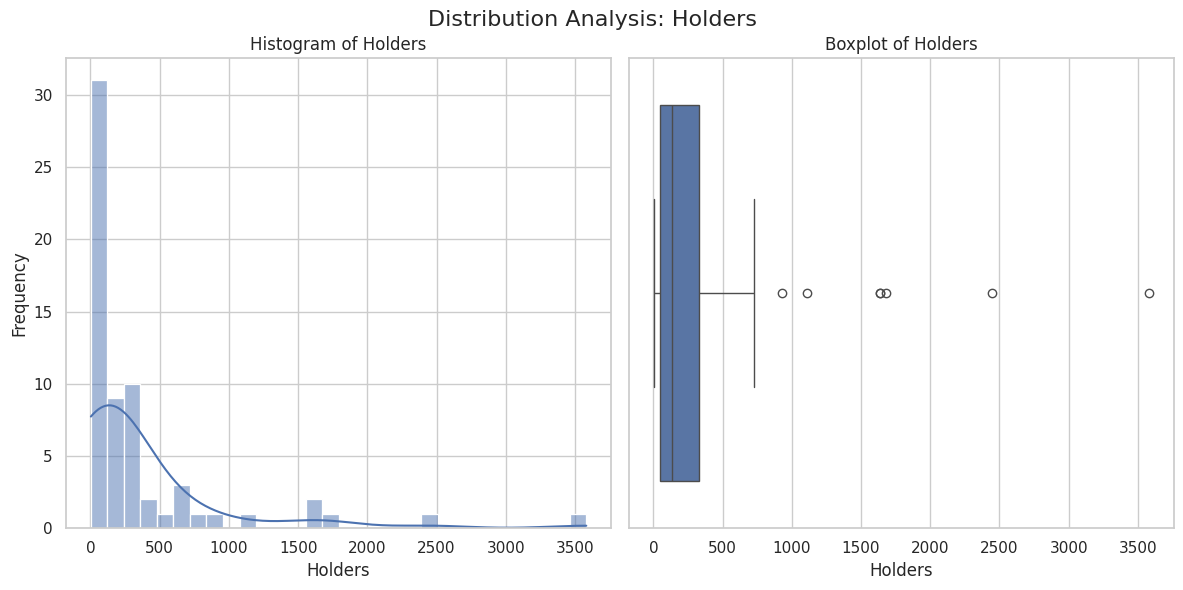

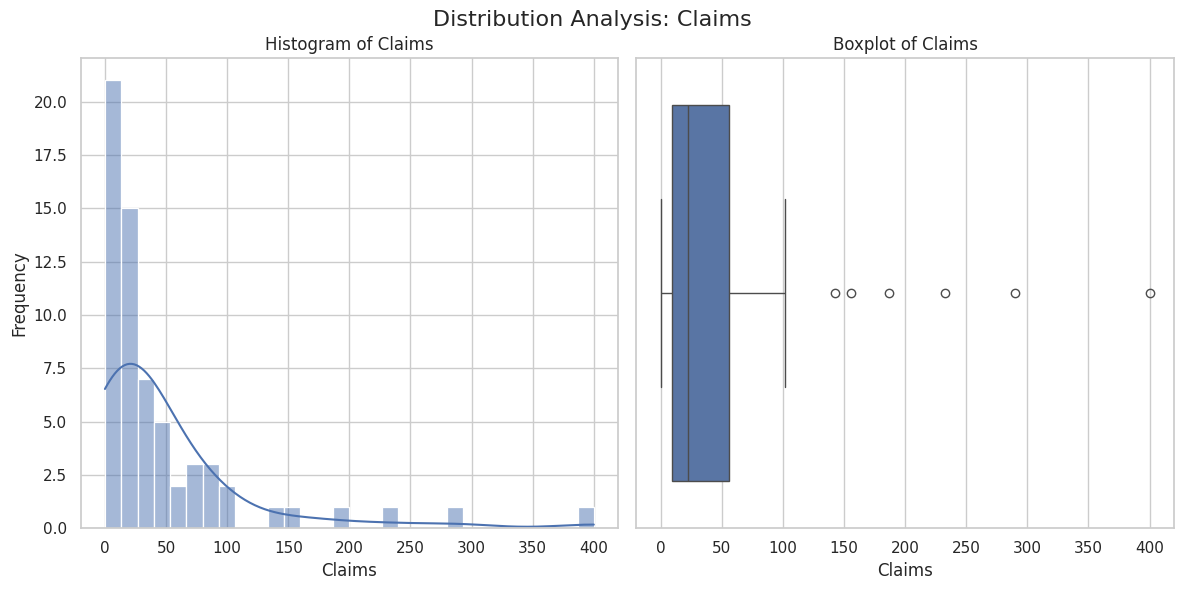

In [11]:
# Visualize the main variables used in the analysis
columns_to_visualize = ['Holders', 'Claims']
visualize_distribution(insurance_df, columns_to_visualize)

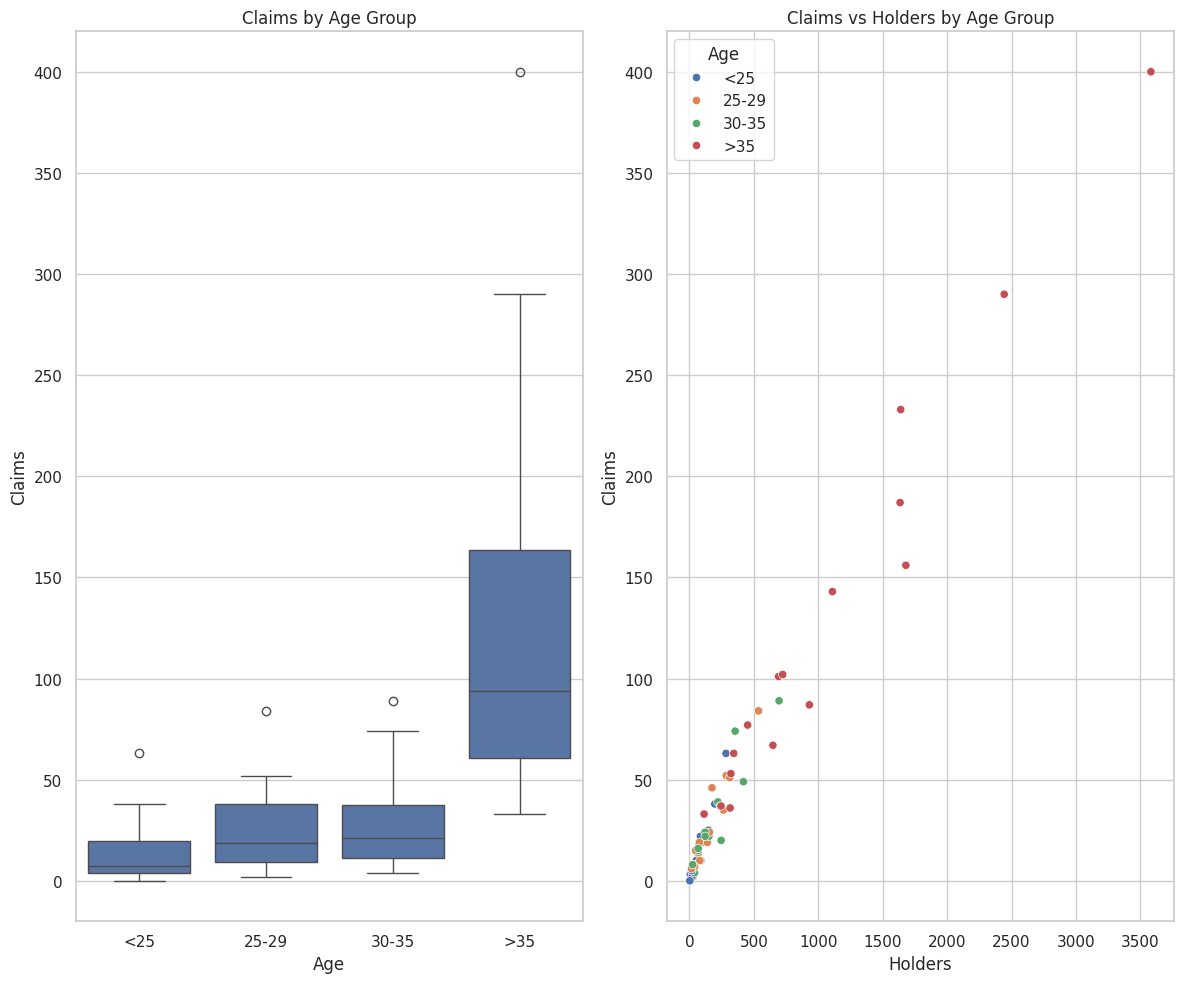

In [12]:
# See the feature and target by the age group
visualize_insurance_data(insurance_df)

## Preprocess the dataset

### Code Analysis: Transforming Categorical 'Age' to Dummy Variables

This code block preprocesses the `Insurance` dataset, focusing on converting the categorical `Age` variable into a numerical format suitable for input into statistical models. This step is necessary because **many modeling algorithms, including regression techniques, require numerical input features rather than categorical text labels.**

1.  **Categorical Setup & Mapping:**
    * The code first ensures the `Age` column is treated as a categorical variable with a defined order.
    * It creates a dictionary (`age_categories`) that maps the internal numerical representation (codes like 0, 1, 2, ...) used by pandas for these categories back to their original string names (e.g., '<25', '25-29', etc.). This map is stored for later use.

2.  **Dummy Variable Creation (`pd.get_dummies`):**
    * A copy of the original DataFrame is made (`insurance_df_trans`).
    * The core transformation is performed using `pd.get_dummies` on the `Age` column. This function creates new binary (0 or 1) columns, one for each category present in the `Age` variable. A '1' in a specific dummy column indicates that the original record belonged to that age category.
    * Crucially, `drop_first=True` is specified. This removes the dummy column corresponding to the first age category. This practice is essential to **avoid perfect multicollinearity** (the "dummy variable trap") among the predictors, which can cause issues in regression models. If 'Age' has 4 categories, this results in 3 new dummy columns.

3.  **Renaming and Formatting:**
    * The code then iterates through the newly created dummy columns (which initially have names like `Age_1`, `Age_2`). It uses the `age_categories` map to rename these columns to be more descriptive, incorporating the original category names (e.g., renaming `Age_1` to `Age_25-29`).
    * It ensures the values in these dummy columns are integers (0 or 1).
    * Finally, it rearranges the columns to place the target variable `Claims` at the end, which is a common convention.

4.  **Result:**
    * The output DataFrame (`insurance_df_trans`) now represents the `Age` variable through several numerical (0/1) dummy columns instead of a single categorical column. This format is now appropriate for use in algorithms requiring numerical inputs. The `.head()` function displays the first few rows of this transformed data.

In [13]:
# The 'Age' column is categorical, with multilabel values
# Transform 'Age' into a dummies variable and them in numerical values
ages = insurance_df['Age'].unique()
insurance_df['Age'] = pd.Categorical(insurance_df['Age'], categories=ages, ordered=True)

# Code the categories into integers and store the mapping
# in a dictionary for later use
age_categories = dict(enumerate(insurance_df['Age'].cat.categories))
print("Coding categories into integers:")
print("=========================================")
print(age_categories)
print("\n")

# Create a copy of the original DataFrame
insurance_df_trans = insurance_df.copy()

# Convert the categorical variable 'Age' into numerical codes
insurance_df_trans['Age'] = insurance_df_trans['Age'].cat.codes
insurance_df_trans['Age'] = insurance_df_trans['Age'].astype('category')

# Transform categorical variable to dummy variables
# Note: drop_first=True is used to avoid the dummy variable trap
insurance_df_trans = pd.get_dummies(insurance_df_trans, columns=['Age'], drop_first=True)

# Rename dummy columns with original category names
for col in [c for c in insurance_df_trans.columns if c.startswith('Age_')]:
    # Extract the numeric code from the column name
    # Note: Assuming the column names are like 'Age_0', 'Age_1', etc.
    code = int(col.split('_')[1])
    
    # Use the mapping dictionary to get the original name
    if code in age_categories:
        # Create the new column name
        new_col_name = f'Age_{age_categories[code]}'
        # Rename the column in the DataFrame
        insurance_df_trans = insurance_df_trans.rename(columns={col: new_col_name})
        
# Ensure that all dummy columns are integers (0 or 1)
for col in [c for c in insurance_df_trans.columns if c.startswith('Age_')]:
    insurance_df_trans[col] = insurance_df_trans[col].astype(int)

# Pass claim to the last column
insurance_df_trans = insurance_df_trans[[col for col in insurance_df_trans.columns if col != 'Claims'] + ['Claims']]

# Display the first few rows of the transformed DataFrame
print("Transformed DataFrame with dummy variables for 'Age' using original names:")
print("=========================================")
insurance_df_trans.head()

Coding categories into integers:
{0: '<25', 1: '25-29', 2: '30-35', 3: '>35'}


Transformed DataFrame with dummy variables for 'Age' using original names:


,Holders,Age_25-29,Age_30-35,Age_>35,Claims
0,197,0,0,0,38
1,264,1,0,0,35
2,246,0,1,0,20
3,1680,0,0,1,156
4,284,0,0,0,63


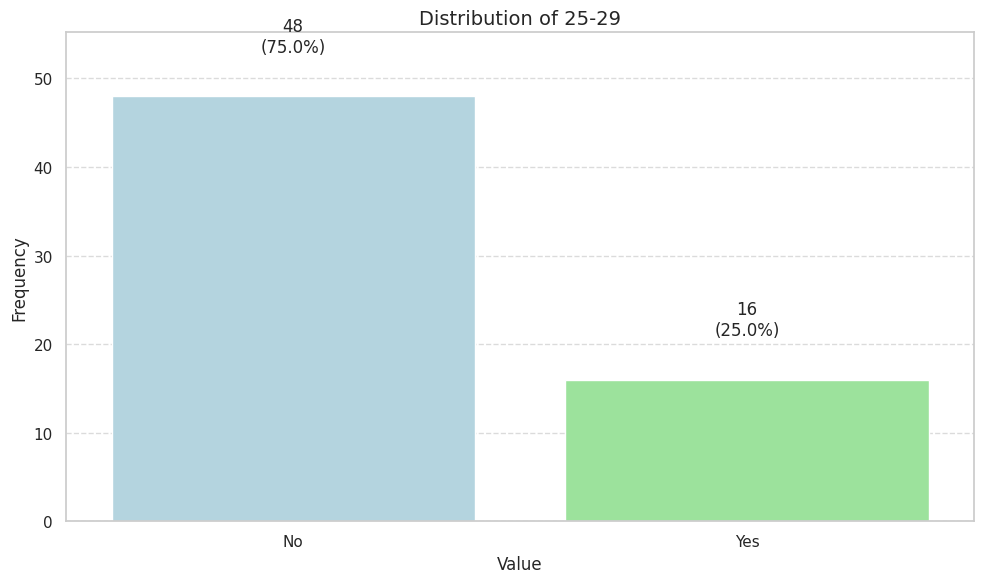

Distribution of 25-29:
No: 48 records (75.00%)
Yes: 16 records (25.00%)



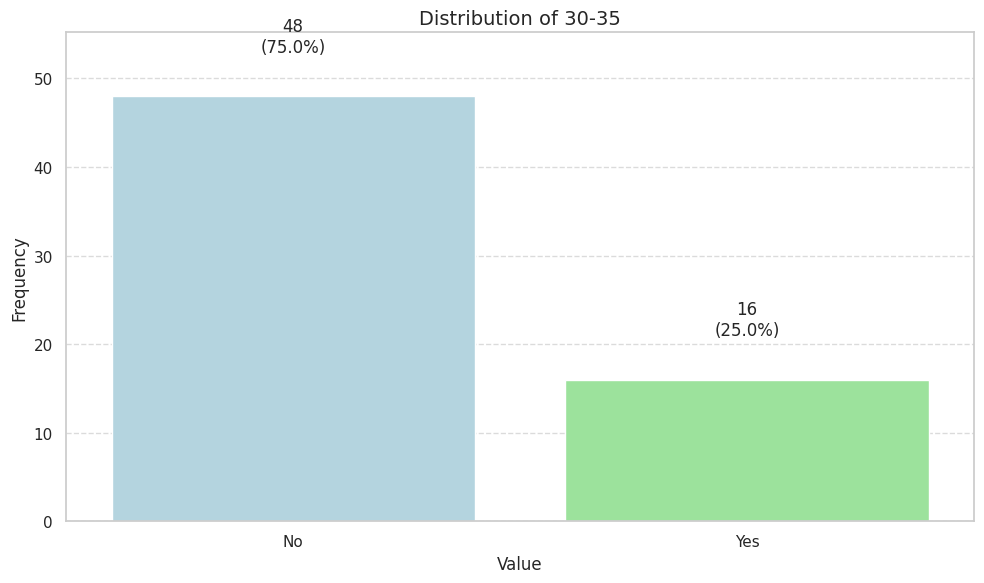

Distribution of 30-35:
No: 48 records (75.00%)
Yes: 16 records (25.00%)



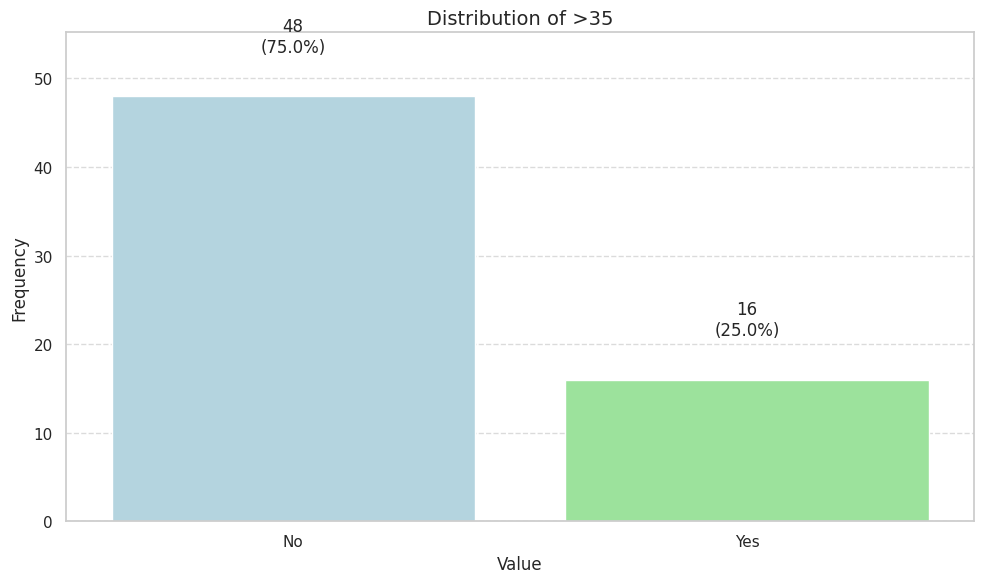

Distribution of >35:
No: 48 records (75.00%)
Yes: 16 records (25.00%)



In [14]:
# Visualizar la distribución de variables dummy de edad
visualize_dummy_distribution(insurance_df_trans)

### Code Analysis: Selective Feature Scaling ('Holders' Only)

This Python code prepares the 'Insurance' dataset (which already has the `Age` variable converted into dummy features) for modeling by applying feature scaling, with specific considerations due to the dataset's characteristics.

1.  **Feature and Target Separation:** The code first isolates the predictor features (`X` - containing `Holders` and `Age_*` dummy variables) from the target variable (`y` - `Claims`).

2.  **Outlier Removal Not Performed:** It's important to note that, unlike in some previous examples with larger datasets, **an explicit outlier removal step is omitted here**. This is a reasonable decision given that the **'Insurance' dataset is very small (only 64 instances)**. Removing outliers from such a small dataset could significantly deplete the available data and potentially discard valuable information, making it generally inadvisable.

3.  **Selective Scaling of `Holders`:**
    * The code identifies that only the numerical `Holders` column requires scaling, while the `Age_*` dummy variables (already being 0 or 1) do not need standardization.
    * `StandardScaler` is initialized and then applied using `fit_transform` **only to the `Holders` column**. This transforms the `Holders` data to have a mean of approximately 0 and a standard deviation of 1, bringing it to a scale comparable to the dummy variables.
    * The `Age_*` dummy columns are intentionally left unchanged in the `X_scaled` DataFrame copy.

4.  **Target Variable:** The `Claims` target variable (`y`) is kept in its original scale and assigned to `y_scaled` without modification.

5.  **Final DataFrame Assembly:** A final DataFrame (`insurance_df_scaled`) is constructed for inspection. It contains the **scaled `Holders` column**, the **original `Age_*` dummy columns**, and the **unscaled `Claims` target variable**. The `.head()` method displays the first few rows of this prepared dataset.

In [15]:
# Define the features and target variable
X = insurance_df_trans.drop(columns=["Claims"])
y = insurance_df_trans["Claims"]

# Create a copy to avoid modifying the original dataframe
X_scaled = X.copy()

# Identify dummy, numeric columns and target variable
dummy_cols = [col for col in X.columns if col.startswith('Age_')]
numeric_cols = ['Holders']  # We only want to scale this column
target_name = "Claims"

# Scale only the 'Holders' column using StandardScaler
scaler = StandardScaler()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# The rest of the columns (dummy variables) remain unchanged
# since they are already in an appropriate scale (0 and 1)

# Define the target variable
y_scaled = y

# Create the final scaled DataFrame with all features
insurance_df_scaled = X_scaled.copy()

# Add the target variable to the DataFrame
insurance_df_scaled[target_name] = y_scaled.values

# Display the first 5 rows of the DataFrame with only 'Holders' scaled
print("DataFrame scaled:")
print("========================================")
insurance_df_scaled.head()

DataFrame scaled:


,Holders,Age_25-29,Age_30-35,Age_>35,Claims
0,-0.271870,0,0,0,38
1,-0.163435,1,0,0,35
2,-0.192567,0,1,0,20
3,2.128249,0,0,1,156
4,-0.131067,0,0,0,63


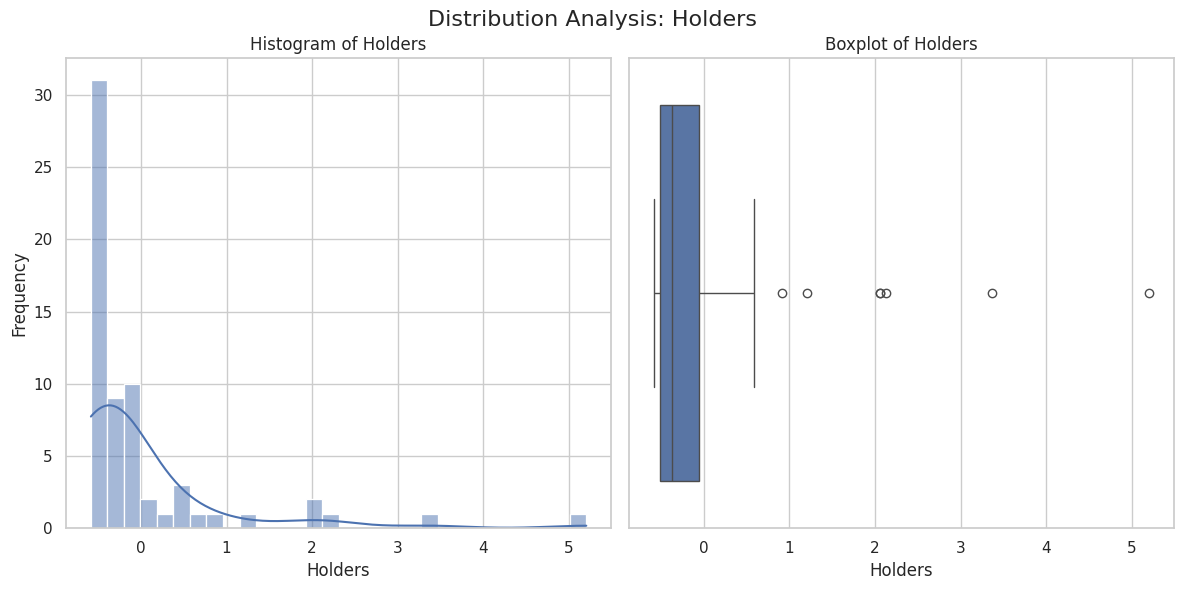

In [16]:
# Visualize the main variables used in the analysis
columns_to_visualize = ['Holders']
visualize_distribution(insurance_df_scaled, columns_to_visualize)

## Fit and test the Poisson regression model

### Fitting the model with formula and original dataset

**Code Description:**

The provided Python code utilizes the `statsmodels` library to fit a Generalized Linear Model (GLM) to the original `insurance_df` dataset.
* **Model Specification:** It explicitly defines a **Poisson regression** model by setting `family=families.Poisson()`. Poisson regression is commonly used for modeling count data, such as the number of `Claims`. By default, it uses a **log link function**, meaning the model predicts the natural logarithm of the expected claim count.
* **Formula:** The formula `"Claims ~ Age + Holders"` defines the model structure: `Claims` is the dependent (response) variable, predicted by the `Age` and `Holders` independent variables. Since `Age` is categorical in the input DataFrame, `statsmodels` automatically converts it into dummy variables for the regression, treating one category as the baseline reference.
* **Fitting:** The `.fit()` method is called to estimate the model parameters using the Iteratively Reweighted Least Squares (IRLS) algorithm.

In [17]:
# Print the message indicating the start of model fitting
print("Fitting Poisson regression model:")
print("=========================================")

# Define the formula for the Poisson regression model
formula = "Claims ~ Age + Holders"
poisson_2_fit = glm(formula=formula, data=insurance_df, family=families.Poisson())

# Fit the Poisson regression model
poisson_model = poisson_2_fit.fit()
print("Model fitted successfully.")

Fitting Poisson regression model:
Model fitted successfully.


### Interpretation of Poisson Regression Coefficients

Here's an interpretation of the coefficients from the Poisson regression model (`Claims ~ Age + Holders`) fitted on the original dataset, based on the summary results shown previously[cite: 1]:

**1. Interpretation on the Log Scale (Direct Coefficients):**

The Poisson model with a log link predicts the *natural logarithm* of the expected count of `Claims`. The coefficients (`coef` column) indicate the change in this log-expected count for a one-unit change in the corresponding predictor, holding other predictors constant[cite: 1].

* **Intercept (2.6146)[cite: 1]:** This is the estimated log of the expected number of claims for the reference `Age` group (which is the category `<25`, as it's not listed explicitly as a coefficient) when the `Holders` variable is 0.
* **`Age[T.25-29]` (0.5174)[cite: 1]:** Compared to the reference group (`<25`), being in the '25-29' age group is associated with an increase of 0.5174 in the log of the expected number of claims, holding `Holders` constant.
* **`Age[T.30-35]` (0.6028)[cite: 1]:** Compared to the reference group (`<25`), being in the '30-35' age group is associated with an increase of 0.6028 in the log of the expected number of claims, holding `Holders` constant.
* **`Age[T.>35]` (1.3587)[cite: 1]:** Compared to the reference group (`<25`), being in the '>35' age group is associated with an increase of 1.3587 in the log of the expected number of claims, holding `Holders` constant.
* **`Holders` (0.0006)[cite: 1]:** For each one-unit increase in the number of policyholders (`Holders`), the log of the expected number of claims is estimated to increase by 0.0006, holding the `Age` group constant.

**2. Interpretation of Exponentiated Coefficients (Rate Ratios / Multiplicative Factors):**

Exponentiating the coefficients (`exp(coef)`) provides a more direct interpretation in terms of *rates* or *multiplicative changes* in the expected number of claims.

* **exp(Intercept) ≈ 13.66:** The estimated *rate* (expected number) of claims for the reference age group ('<25') with 0 `Holders` is approximately 13.66 claims.
* **exp(`Age[T.25-29]`) ≈ 1.68:** Holding `Holders` constant, the expected claim rate for the '25-29' age group is **1.68 times** the expected claim rate of the reference group ('<25').
* **exp(`Age[T.30-35]`) ≈ 1.83:** Holding `Holders` constant, the expected claim rate for the '30-35' age group is **1.83 times** the expected claim rate of the reference group.
* **exp(`Age[T.>35]`) ≈ 3.90:** Holding `Holders` constant, the expected claim rate for the '>35' age group is **3.90 times** the expected claim rate of the reference group. This indicates the highest relative claim rate among the age groups compared to the baseline.
* **exp(`Holders`) ≈ 1.0006:** For each additional policyholder, the expected number of claims is estimated to be multiplied by **1.0006** (or increase by about 0.06%), holding the `Age` group constant.

In essence, the model indicates significantly higher claim rates for older age groups compared to the baseline (<25) group and a small positive association between the number of policyholders and the expected number of claims.

In [18]:
# Print the summary of the fitted model
print("Summary of the fitted Poisson regression model:")
print("=========================================")
print(poisson_model.summary())

Summary of the fitted Poisson regression model:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                   64
Model:                            GLM   Df Residuals:                       59
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -545.35
Date:                Wed, 16 Apr 2025   Deviance:                       773.38
Time:                        19:21:21   Pearson chi2:                     819.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------


In [19]:
# Print the coefficients
print("Coefficients:")
print("=========================================")

# Extract and print coefficients and p-values
print(poisson_model.params)

Coefficients:
Intercept       2.614614
Age[T.25-29]    0.517357
Age[T.30-35]    0.602752
Age[T.>35]      1.358703
Holders         0.000636
dtype: float64


In [20]:
# Calculate and print additional model metrics
print("Model Metrics:")
print("=========================================")
print(f"Log-Likelihood: {poisson_model.llf:.4f}")
print(f"AIC: {poisson_model.aic:.4f}")
print(f"BIC: {poisson_model.bic:.4f}")

Model Metrics:
Log-Likelihood: -545.3520
AIC: 1100.7041
BIC: 528.0085


In [21]:
# Check for overdispersion (variance > mean)
print("Checking for overdispersion:")
print("=========================================")

# Divide the dataset into features and target variable
df = insurance_df.drop(columns=["Claims"])
y = insurance_df["Claims"]

# Calculate the residuals
y_pred = poisson_model.predict(df)
residuals = y - y_pred

# Calculate Pearson's chi-squared statistic
# and degrees of freedom
pearson_chi2 = np.sum(residuals**2 / y_pred)
degrees_of_freedom = len(y) - len(poisson_model.params)
dispersion = pearson_chi2 / degrees_of_freedom

# Print the dispersion parameter
print(f"Pearson's Chi-squared statistic: {pearson_chi2:.4f}")
print(f"Dispersion parameter: {dispersion:.4f}")

Checking for overdispersion:
Pearson's Chi-squared statistic: 819.2452
Dispersion parameter: 13.8855


### Fitting the model with formula and scaled dataset

### Code Analysis: Poisson Regression with Explicit Dummy Variables

This code block fits another Poisson regression model using `statsmodels.formula.api.glm` to predict the number of `Claims`. It shares the same goal as the previous Poisson model fit but differs significantly in how it handles the `Age` predictor, reflecting prior data transformations.

1.  **Input Data:** The model utilizes the `insurance_df_scaled` DataFrame. This DataFrame is distinct because the original categorical `Age` variable has already been **transformed into numerical dummy variables** (e.g., `Age_25-29`, `Age_30-35`, `Age_>35`) in previous preprocessing steps, with one category dropped to serve as the reference. It also contains the scaled `Holders` variable.

2.  **Formula Specification - Key Difference:**
    * The `formula` string is now: `"Claims ~ Q('Age_25-29') + Q('Age_30-35') + Q('Age_>35') + Holders"`.
    * Unlike the first model which used the original categorical `Age` column (`~ Age + ...`) and relied on `statsmodels` to create dummies internally, this formula **explicitly lists the pre-existing dummy variable columns** as predictors.
    * The `Q()` function is necessary to wrap the dummy variable names because they contain special characters (`-`, `>`), ensuring the formula parser correctly identifies them as DataFrame column names.

3.  **Model Setup:** The model is still specified as a Poisson GLM (`family=families.Poisson()`) with a log link function.

4.  **Fitting:** The `.fit()` method estimates the coefficients for the explicitly provided dummy variables and the `Holders` variable.

**In summary:** This code fits the same type of Poisson regression model conceptually, but it operates on a DataFrame where the categorical `Age` predictor has already been manually converted into dummy variables. This necessitates explicitly including these dummy variables in the model formula, rather than relying on automatic conversion by `statsmodels`.

In [22]:
# Print the message indicating the start of model fitting
print("Fitting Poisson regression model:")
print("=========================================")

# Define the formula for the Poisson regression model
formula = "Claims ~ Q('Age_25-29') + Q('Age_30-35') + Q('Age_>35') + Holders"
poisson_2_fit = glm(formula=formula, data=insurance_df_scaled, family=families.Poisson())

# Fit the Poisson regression model
poisson_model_2 = poisson_2_fit.fit()
print("Model fitted successfully.")

Fitting Poisson regression model:
Model fitted successfully.


### Analysis of Poisson Regression Results (Scaled Data with Explicit Dummies)

This analysis examines the results of the second Poisson regression model[cite: 2], which was fitted using the `insurance_df_scaled` dataset (scaled `Holders`, explicit `Age` dummies). We interpret the coefficients and compare the results to the first model[cite: 1].

**1. Coefficient Interpretation:**

* **Log Scale Coefficients:**
    * **Intercept (2.8469)[cite: 2]:** Represents the estimated log-expected `Claims` for the reference `Age` group ('<25') when the standardized `Holders` variable is 0 (i.e., when `Holders` is at its mean value in the dataset). This differs from the first model's intercept[cite: 1], which was for `Holders` = 0.
    * **`Q('Age_...')` (0.5174, 0.6028, 1.3587)[cite: 2]:** These coefficients for the `Age` dummy variables are **identical** to the first model[cite: 1]. They represent the additive change in log-expected `Claims` for each respective age group compared to the reference group ('<25'), holding standardized `Holders` constant.
    * **`Holders` (0.3932)[cite: 2]:** This coefficient is significantly different numerically from the first model (0.0006) [cite: 1] because `Holders` is now scaled. It represents the change in log-expected `Claims` associated with a **one standard deviation increase** in the `Holders` variable, holding `Age` group constant.

* **Exponentiated Coefficients (Rate Ratios / Multiplicative Factors):**
    * **exp(Intercept) ≈ 17.23:** The estimated claim rate for the reference group ('<25') at the *average* number of `Holders` is ~17.23.
    * **exp(`Q('Age_...')`) ≈ 1.68, 1.83, 3.90:** The Rate Ratios comparing the '25-29', '30-35', and '>35' age groups to the reference group ('<25') remain **unchanged** from the first model. For example, the '>35' group still has an expected claim rate 3.90 times higher than the '<25' group.
    * **exp(`Holders`) ≈ 1.48:** A **one standard deviation increase** in the number of policyholders is associated with multiplying the expected claim rate by approximately **1.48** (a 48% increase), holding `Age` group constant. This reflects the same positive relationship as before, but expressed relative to the standard deviation of `Holders`.

**2. Comparison and Significance of Changes:**

* **Statistical Significance:** All coefficients remain **highly statistically significant (P>|z| = 0.000)**[cite: 2], identical to the first model.
* **Model Fit:** The overall model fit statistics (Log-Likelihood, Deviance, Pearson chi2) are **identical** to the first model[cite: 1, 2]. This means the **significant overdispersion noted previously still persists** to the same degree.
* **Overall Impact:** While scaling the `Holders` variable altered its coefficient's value and interpretation (now per standard deviation instead of per unit), **this change was not significant in terms of the model's overall findings or fit**. The conclusions remain the same: `Age` and `Holders` are significant predictors, older age groups have higher rates, more holders mean slightly higher rates, and the Poisson model suffers from overdispersion in this dataset. The necessity of considering an alternative like a Negative Binomial model remains unchanged.

In [23]:
# Print the summary of the fitted model
print("Summary of the fitted Poisson regression model:")
print("=========================================")
print(poisson_model_2.summary())

Summary of the fitted Poisson regression model:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                   64
Model:                            GLM   Df Residuals:                       59
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -545.35
Date:                Wed, 16 Apr 2025   Deviance:                       773.38
Time:                        19:21:21   Pearson chi2:                     819.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

In [24]:
# Print the coefficients
print("Coefficients:")
print("=========================================")

# Extract and print coefficients and p-values
print(poisson_model_2.params)

Coefficients:
Intercept         2.846882
Q('Age_25-29')    0.517357
Q('Age_30-35')    0.602752
Q('Age_>35')      1.358703
Holders           0.393210
dtype: float64


In [25]:
# Calculate and print additional model metrics
print("Model Metrics:")
print("=========================================")
print(f"Log-Likelihood: {poisson_model_2.llf:.4f}")
print(f"AIC: {poisson_model_2.aic:.4f}")
print(f"BIC: {poisson_model_2.bic:.4f}")

Model Metrics:
Log-Likelihood: -545.3520
AIC: 1100.7041
BIC: 528.0085


In [26]:
# Check for overdispersion (variance > mean)
print("Checking for overdispersion:")
print("=========================================")

# Divide the dataset into features and target variable
df = insurance_df_scaled.drop(columns=["Claims"])
y = insurance_df_scaled["Claims"]

# Calculate the residuals
y_pred = poisson_model_2.predict(df)
residuals = y - y_pred

# Calculate Pearson's chi-squared statistic
# and degrees of freedom
pearson_chi2 = np.sum(residuals**2 / y_pred)
degrees_of_freedom = len(y) - len(poisson_model_2.params)
dispersion = pearson_chi2 / degrees_of_freedom

# Print the dispersion parameter
print(f"Pearson's Chi-squared statistic: {pearson_chi2:.4f}")
print(f"Dispersion parameter: {dispersion:.4f}")

Checking for overdispersion:
Pearson's Chi-squared statistic: 819.2452
Dispersion parameter: 13.8855


### Perform 10-fold Cross-Validation

### General Analysis: Poisson Regression with 10-Fold Cross-Validation

This section of the code implements a 10-fold cross-validation procedure to evaluate the performance and stability of the Poisson regression model fitted on the scaled insurance dataset. Cross-validation provides a more reliable estimate of how the model might perform on unseen data compared to a single train/test split.

The process unfolds across the four code blocks:

1.  **Data Preparation:**
    * The predictor features (`X` - including scaled `Holders` and `Age_*` dummies) and the target variable (`y` - `Claims`) are extracted from the `insurance_df_scaled` DataFrame.
    * `sm.add_constant(X)` is used to explicitly add a constant (intercept) column to the feature matrix `X`. This is required when using the `statsmodels` `GLM` function directly with feature arrays/DataFrames instead of the formula interface.

2.  **Deviance Metric Definition:**
    * A custom function `poisson_deviance` is defined. Poisson deviance is a standard goodness-of-fit measure for Poisson models, comparing the fitted model to a saturated model. It's generally a more appropriate error metric for count data models than MSE. The function includes checks to prevent errors with zero values.

3.  **Cross-Validation Loop:**
    * `KFold` from `sklearn.model_selection` is set up to divide the data into 10 folds (`n_splits=10`), shuffling the data first (`shuffle=True`) with a fixed `random_state` for reproducibility.
    * The code iterates 10 times. In each iteration ("fold"):
        * The data is split into a 90% training set (`X_train`, `y_train`) and a 10% test set (`X_test`, `y_test`).
        * A new Poisson GLM (`sm.families.Poisson()`) is fitted **using only the training data** for that fold.
        * Predictions are made on the corresponding **test data**.
        * Two metrics are calculated comparing predictions to the true test values (`y_test`): Mean Squared Error (MSE) and the custom `poisson_deviance`. These are stored for later averaging.

4.  **Results Aggregation:**
    * After the loop completes, the code calculates the **average and standard deviation** of the MSE and Poisson Deviance values collected across all 10 folds.
    * These average metrics (Mean MSE and Mean Deviance) and their standard deviations are printed, providing a summary of the model's expected out-of-sample performance and its consistency across different subsets of the data.

In essence, this section robustly evaluates the chosen Poisson model configuration by training and testing it multiple times on different portions of the (small) dataset, using metrics relevant to count data (Deviance) alongside a more standard one (MSE).

In [27]:
# Prepare the data for the Poisson regression model with 10-fold cross-validation
print("Preparing data for 10-fold cross-validation:")
print("=========================================")

# Define the target variable and features
y = insurance_df_scaled['Claims']
X = insurance_df_scaled.drop('Claims', axis=1)
X = sm.add_constant(X)
print("Data prepared successfully.")

Preparing data for 10-fold cross-validation:
Data prepared successfully.


In [28]:
# Define the poisson deviance function
def poisson_deviance(y_true, y_pred):
    """
    Calculate the Poisson deviance for the given true and predicted values.
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted values
    
    Returns:
    - deviance: Poisson deviance value
    """
    # Avoid division by zero
    y_pred = np.maximum(y_pred, 1e-10)
    y_true = np.maximum(y_true, 1e-10)
    
    # Elements of the deviance formula
    dev_elements = np.where(
        y_true > 0,
        y_true * np.log(y_true / y_pred) - (y_true - y_pred),
        -y_pred
    )
    
    return 2 * np.sum(dev_elements)

In [29]:
# Prepare for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the variables to save the results
mse_values = []
poisson_deviance_values = []

# Print the message indicating the start of cross-validation
print("Performing 10-fold Cross-Validation")
print("=========================================")

# Initialize the fold counter
fold = 1

# Perform 10-fold cross-validation
for train_idx, test_idx in kf.split(X):
    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Fit the model on training data
    poisson_cv = GLM(y_train, X_train, family=sm.families.Poisson())
    poisson_cv_results = poisson_cv.fit()
    
    # Predict on test data
    y_pred = poisson_cv_results.predict(X_test)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    
    # Calculate Poisson deviance
    dev = poisson_deviance(y_test, y_pred)
    poisson_deviance_values.append(dev)
    
    print(f"Fold {fold}: MSE = {mse:.4f}, Deviance = {dev:.4f}")
    fold += 1

# Print that the cv is done
print("Cross-validation completed.")

Performing 10-fold Cross-Validation
Fold 1: MSE = 579.2884, Deviance = 124.7049
Fold 2: MSE = 251.7769, Deviance = 80.8131
Fold 3: MSE = 546.2392, Deviance = 118.2865
Fold 4: MSE = 559.6663, Deviance = 131.7806
Fold 5: MSE = 334.5176, Deviance = 54.2732
Fold 6: MSE = 1445.2678, Deviance = 92.0034
Fold 7: MSE = 205.6791, Deviance = 64.2859
Fold 8: MSE = 929.3953, Deviance = 64.6438
Fold 9: MSE = 627.8173, Deviance = 102.8757
Fold 10: MSE = 69754.9672, Deviance = 545.0347
Cross-validation completed.


In [32]:
# Calculate average metrics for the 10 folds
print("Calculating average metrics:")
print("=========================================")
mean_mse = np.mean(mse_values)
mean_deviance = np.mean(poisson_deviance_values)
std_mse = np.std(mse_values)
std_deviance = np.std(poisson_deviance_values)
print("Metrics calculated successfully.")
print("\n")

# Print the average metrics
print(f"Cross-Validation Results:")
print("=========================================")
print(f"Mean MSE: {mean_mse:.4f} (± {std_mse:.4f})")
print(f"Mean Deviance: {mean_deviance:.4f} (± {std_deviance:.4f})")

Calculating average metrics:
Metrics calculated successfully.


Cross-Validation Results:
Mean MSE: 7523.4615 (± 20746.6678)
Mean Deviance: 137.8702 (± 138.1036)


### Analysis of 10-Fold Cross-Validation Results for Poisson Model

The 10-fold cross-validation was performed to assess how well the Poisson regression model (fitted on the dataset with scaled `Holders` and dummy `Age` variables) generalizes to unseen data. The average results across the 10 folds are[cite: 1]:

* **Mean MSE:** 7523.46 (± 20746.67)
* **Mean Deviance:** 137.87 (± 138.10)

**Interpretation:**

1.  **Variability:** The most critical insight comes from the standard deviations associated with the mean metrics. Both standard deviations are extremely large, particularly relative to their means:
    * The standard deviation for MSE (≈ 20747) is almost three times the mean MSE (≈ 7523).
    * The standard deviation for Deviance (≈ 138.1) is virtually equal to the mean Deviance (≈ 137.9).
    * This indicates **very high variance** in the model's performance across the 10 different test folds. The model's predictive error and goodness-of-fit are highly inconsistent depending on the specific subset of data it is tested on.

2.  **Connection to Overdispersion:** This high variability is consistent with the **significant overdispersion** identified in the initial model fit (where Deviance and Pearson Chi2 were much larger than the degrees of freedom). Overdispersion means the Poisson model's assumption (variance equals mean) is violated, leading to a poor fit and unstable predictions, especially with a small dataset (n=64).

**Summary Finding: How well does the Poisson model generalize?**

Based on the 10-fold cross-validation results, the Poisson model demonstrates **poor generalization ability** for this dataset. The extremely high standard deviations for both MSE and Deviance indicate that its performance on unseen data is **highly unstable and unreliable**. This poor generalization is likely a consequence of the model misspecification due to **overdispersion** in the `Claims` data, combined with the small sample size. Therefore, predictions from this specific Poisson model on new data would likely have large and inconsistent errors. An alternative model, such as Negative Binomial regression, which explicitly accounts for overdispersion, would be recommended to achieve better generalization.